# 01) Data + Baseline Volatility (SPY)
Goal: download daily prices, compute log returns, and build baseline volatility (rolling + EWMA).

In [1]:
!pip -q install yfinance

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 4)

TICKER = "SPY"
START = "2004-01-01"
END = None

In [2]:
df = yf.download(TICKER, start=START, end=END, auto_adjust=True, progress=False)
df = df.rename(columns=str.lower)

df.head()

Price,close,high,low,open,volume
Ticker,spy,spy,spy,spy,spy
Date,,,,,
2004-01-02,74.035538,74.674520,73.702734,74.374994,38072300
2004-01-05,74.840912,74.894157,74.275141,74.341706,27959800
2004-01-06,74.914124,75.033933,74.548037,74.654537,20472800
2004-01-07,75.167061,75.253588,74.474828,74.807632,30170400
2004-01-08,75.466599,75.486571,75.060577,75.380071,36438400


In [3]:
prices = df[["close"]].copy()
prices = prices.dropna()
prices.tail()

Price,close
Ticker,spy
Date,
2026-01-30,691.969971
2026-02-02,695.409973
2026-02-03,689.530029
2026-02-04,686.190002
2026-02-05,677.619995


In [4]:
# Computing log-returns
prices["log_return"] = np.log(prices["close"] / prices["close"].shift(1))
prices = prices.dropna()

prices[["close", "log_return"]].head()

Price,close,log_return
Ticker,spy,
Date,,
2004-01-05,74.840912,0.010819
2004-01-06,74.914124,0.000978
2004-01-07,75.167061,0.003371
2004-01-08,75.466599,0.003977
2004-01-09,74.807671,-0.008770


In [5]:
# Baseline vol #1: rolling 20-day
N = 20
prices["vol_20d"] = np.sqrt(252) * prices["log_return"].rolling(N).std()
prices[["log_return", "vol_20d"]].tail(10)

Price,log_return,vol_20d
Ticker,,
Date,,
2026-01-23,0.000363,0.105486
2026-01-26,0.005065,0.106295
2026-01-27,0.003976,0.107139
2026-01-28,-0.000101,0.106148
2026-01-29,-0.001986,0.106352
2026-01-30,-0.002987,0.103065
2026-02-02,0.004959,0.104100
2026-02-03,-0.008491,0.106833


In [6]:
lam = 0.94

# initialize with sample variance of first 60 returns
init_window = 60
r = prices["log_return"].values

sigma2 = np.empty_like(r)
sigma2[:] = np.nan
sigma2[init_window] = np.var(r[:init_window], ddof=1)

for t in range(init_window + 1, len(r)):
    sigma2[t] = lam * sigma2[t-1] + (1 - lam) * (r[t-1] ** 2)

prices["vol_ewma"] = np.sqrt(252 * sigma2)
prices[["vol_20d", "vol_ewma"]].dropna().head()

Price,vol_20d,vol_ewma
Ticker,,
Date,,
2004-03-31,0.156758,0.120566
2004-04-01,0.158238,0.116979
2004-04-02,0.160367,0.115785
2004-04-05,0.155500,0.116014
2004-04-06,0.155232,0.114480


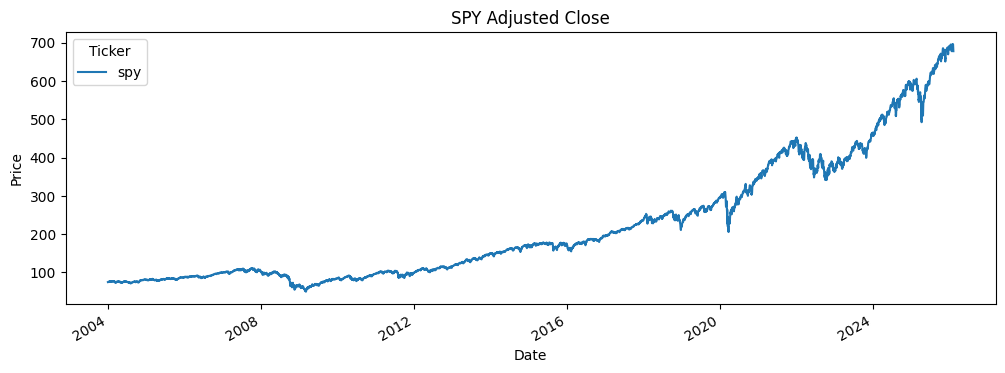

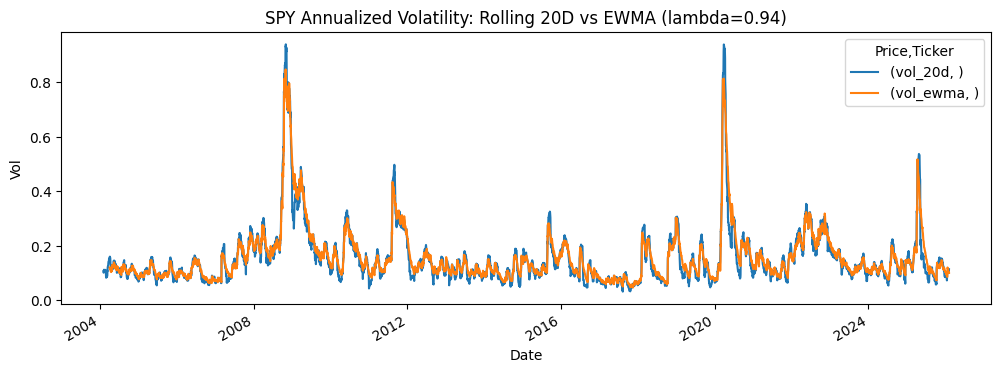

In [7]:
prices["close"].plot()
plt.title(f"{TICKER} Adjusted Close")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

prices[["vol_20d", "vol_ewma"]].plot()
plt.title(f"{TICKER} Annualized Volatility: Rolling 20D vs EWMA (lambda={lam})")
plt.xlabel("Date")
plt.ylabel("Vol")
plt.show()

In [8]:
summary = prices[["log_return", "vol_20d", "vol_ewma"]].describe().T
summary

,,count,mean,std,min,25%,50%,75%,max
Price,Ticker,,,,,,,,
log_return,,5558.0,0.000398,0.011813,-0.115886,-0.003935,0.000726,0.005745,0.135577
vol_20d,,5539.0,0.154455,0.108982,0.031860,0.092631,0.125981,0.180258,0.939714
vol_ewma,,5498.0,0.158083,0.102208,0.047003,0.101244,0.127557,0.182009,0.847653


## Forecast target

We evaluate volatility forecasts against a simple realized variance proxy:

$RV_{t+1} = 252 · r_{t+1}²$

Yes, this is noisy, but standard when only daily data is available.

In [9]:
# next-day realized variance proxy
prices["rv_next"] = 252 * prices["log_return"].shift(-1)**2

prices[["log_return", "rv_next"]].dropna().head()

Price,log_return,rv_next
Ticker,,
Date,,
2004-01-05,0.010819,0.000241
2004-01-06,0.000978,0.002863
2004-01-07,0.003371,0.003986
2004-01-08,0.003977,0.019381
2004-01-09,-0.008770,0.013643


In [14]:
eval_df["var_20d"] = eval_df["vol_20d"]**2
eval_df["var_ewma"] = eval_df["vol_ewma"]**2

eval_df[["vol_20d","vol_ewma","var_20d","var_ewma","rv_next"]].head()

Price,vol_20d,vol_ewma,var_20d,var_ewma,rv_next
Ticker,,,,,
Date,,,,,
2004-03-31,0.156758,0.120566,0.024573,0.014536,0.009055
2004-04-01,0.158238,0.116979,0.025039,0.013684,0.014288
2004-04-02,0.160367,0.115785,0.025717,0.013406,0.007568
2004-04-05,0.155500,0.116014,0.024180,0.013459,0.002604
2004-04-06,0.155232,0.114480,0.024097,0.013106,0.001395


In [16]:
mse_20d = np.mean((eval_df["var_20d"] - eval_df["rv_next"])**2)
mse_ewma = np.mean((eval_df["var_ewma"] - eval_df["rv_next"])**2)

pd.Series({"Rolling 20D": mse_20d, "EWMA": mse_ewma}, name="MSE")

,MSE
Rolling 20D,0.018149
EWMA,0.017421


In [18]:
eps = 1e-8  # numerical floor

eval_df["rv_next_eps"] = np.maximum(eval_df["rv_next"], eps)

eval_df[["rv_next", "rv_next_eps"]].describe()

Price,rv_next,rv_next_eps
Ticker,,
count,5497.000000,5.497000e+03
mean,0.035434,3.543385e-02
std,0.145570,1.455704e-01
min,0.000000,1.000000e-08
25%,0.001054,1.054176e-03
50%,0.006333,6.332990e-03
75%,0.025451,2.545067e-02
max,4.632066,4.632066e+00


In [19]:
qlike_20d = np.mean(
    qlike(eval_df["var_20d"], eval_df["rv_next_eps"])
)

qlike_ewma = np.mean(
    qlike(eval_df["var_ewma"], eval_df["rv_next_eps"])
)

pd.Series(
    {"Rolling 20D": qlike_20d, "EWMA": qlike_ewma},
    name="QLIKE"
)

,QLIKE
Rolling 20D,1.712982
EWMA,1.674936


## Conclusion — Baseline volatility forecasting

In this notebook, we evaluate two standard volatility forecasting methods using daily SPY returns: a 20-day rolling historical volatility and an Exponentially Weighted Moving Average (EWMA). Forecasts are assessed against next-day realized variance, a common proxy when higher-frequency data is unavailable.

Both models capture volatility clustering, but they differ in responsiveness. The rolling model weights recent history equally, while EWMA places greater emphasis on recent returns, allowing faster adjustment to market shocks.

Forecast performance is measured using Mean Squared Error (MSE) and QLIKE loss. EWMA outperforms the rolling benchmark on both metrics, indicating slightly better average accuracy and a lower tendency to underestimate volatility during periods of stress. The improvement, however, is modest, highlighting a key practical insight: in volatility forecasting, simpler models often perform comparably, and increased complexity does not necessarily yield large gains.

These results establish EWMA as a strong and realistic baseline, providing a clear benchmark against which more complex volatility models can be evaluated.

In [21]:
import os
os.makedirs("data/processed", exist_ok=True)

In [22]:
prices.to_csv("data/processed/spy_vol_baselines.csv")